In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
df1 = pd.read_csv('../Data/public_fac.csv')
df2 = pd.read_csv('../Data/prop_values.csv')

In [ ]:
df1

In [5]:
df1['score'] = 1
df_p = df1.pivot_table(index = 'zipcode', columns = 'facgroup', aggfunc='sum', values = 'score')
df_p = df_p.fillna(0)

In [6]:
df2_g = df2[['zip', 'revised_market_value']].groupby(by = 'zip').mean()

In [7]:
df_p['zip'] = df_p.index
df_m = df_p.merge(df2_g, left_on='zip', right_on='zip')

In [ ]:
df_s

In [8]:
to_scale = df_m.columns[:-1].to_list()
to_scale.append('revised_market_value')

In [9]:
scaler = StandardScaler()
df_s = pd.DataFrame(scaler.fit_transform(df_m[to_scale]), columns = to_scale)

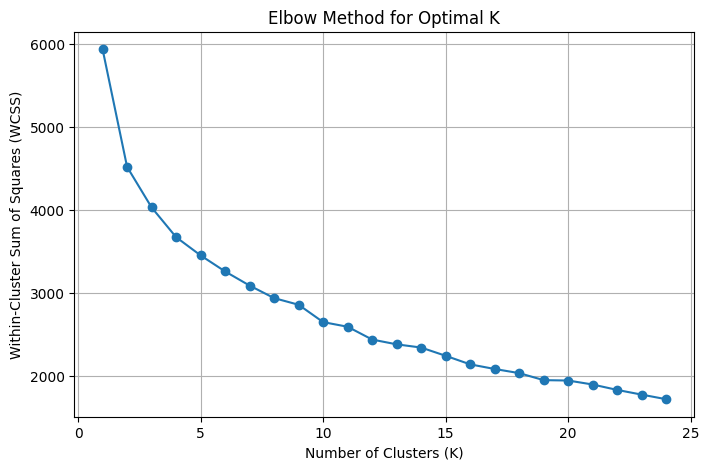

In [14]:
wcss = []
n_max = 25
for k in range(1, n_max):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_s[to_scale])
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(8, 5))
plt.plot(range(1,n_max), wcss, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [15]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_s["Cluster"] = kmeans.fit_predict(df_s[to_scale])
df_m["Cluster"] = kmeans.fit_predict(df_s[to_scale])

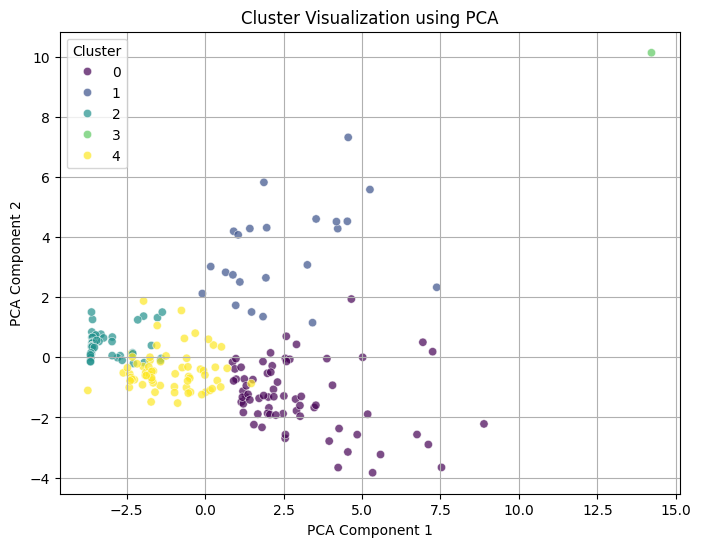

In [19]:
import seaborn as sns

pca = PCA(2)
pca_components = pca.fit_transform(df_s[to_scale])
df_s["PCA1"], df_s["PCA2"] = pca_components[:, 0], pca_components[:, 1]

pca_loadings = pd.DataFrame(
        pca.components_,
        columns=to_scale,
        index=["PCA1", "PCA2"]
    )

plt.figure(figsize=(8,6))
sns.scatterplot(x=df_s["PCA1"], y=df_s["PCA2"], hue=df_s["Cluster"], palette="viridis", alpha=0.7)
plt.title("Cluster Visualization using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [20]:
pca_all = PCA().fit(df_s[to_scale])

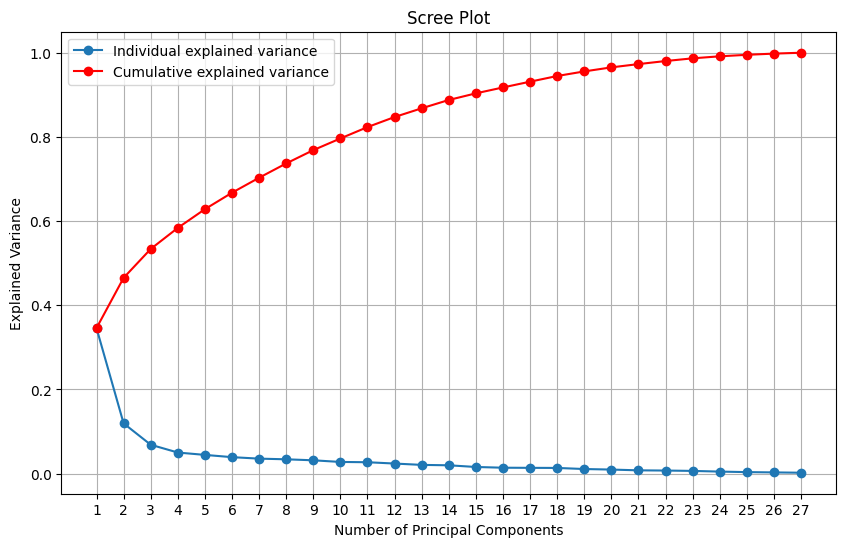

In [24]:
import numpy as np
plt.figure(figsize=(10,6))
# Plotting the explained variance for each component
plt.plot(range(1, len(pca_all.explained_variance_ratio_) + 1),
         pca_all.explained_variance_ratio_,
         marker='o', label='Individual explained variance')

# Plotting the cumulative explained variance
plt.plot(range(1, len(pca_all.explained_variance_ratio_) + 1),
         np.cumsum(pca_all.explained_variance_ratio_),
         marker='o', color='r', label='Cumulative explained variance')

plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(pca_all.explained_variance_ratio_) + 1))
plt.grid()
plt.legend()
plt.show()

## PCA Analysis
Based on the plot above, it is prudent to include 5 components, at a minimum; however, that only explains ~60% of the variance. Typically we want to be around 80-90%. An optimal for this dataset might be around 15 different components. We'll select that for our PCA to keep.

In [25]:
explained_variance = pca_all.explained_variance_ratio_
pca_loadings = pd.DataFrame(
        pca_all.components_.T,
        index=to_scale,
        columns=[f'PC{i+1}' for i in range(len(explained_variance))]
    )

In [30]:
pca_loadings['PC4'].sort_values(ascending=False)

MATERIAL SUPPLIES AND MARKETS                    0.490051
ADULT SERVICES                                   0.302804
OTHER PROPERTY                                   0.298808
CITY AGENCY PARKING, MAINTENANCE, AND STORAGE    0.221633
PUBLIC SAFETY                                    0.168258
revised_market_value                             0.131494
SOLID WASTE                                      0.109467
CULTURAL INSTITUTIONS                            0.106622
HISTORICAL SITES                                 0.104605
YOUTH SERVICES                                   0.069362
TRANSPORTATION                                   0.043502
EMERGENCY SERVICES                               0.043316
PARKS AND PLAZAS                                -0.001185
HUMAN SERVICES                                  -0.018554
JUSTICE AND CORRECTIONS                         -0.053493
HEALTH CARE                                     -0.060291
OFFICES, TRAINING, AND TESTING                  -0.069575
HIGHER EDUCATI

In [16]:
df_m.groupby('Cluster').mean()

,ADULT SERVICES,CAMPS,CHILD SERVICES AND WELFARE,"CITY AGENCY PARKING, MAINTENANCE, AND STORAGE",CULTURAL INSTITUTIONS,DAY CARE AND PRE-KINDERGARTEN,EMERGENCY SERVICES,HEALTH CARE,HIGHER EDUCATION,HISTORICAL SITES,...,PUBLIC SAFETY,SCHOOLS (K-12),SOLID WASTE,TELECOMMUNICATIONS,TRANSPORTATION,VOCATIONAL AND PROPRIETARY SCHOOLS,WATER AND WASTEWATER,YOUTH SERVICES,zip,revised_market_value
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1.405797,2.057971,19.623188,4.043478,11.579710,37.869565,2.144928,29.826087,0.521739,5.463768,...,1.130435,30.753623,14.608696,0.028986,23.318841,2.608696,0.724638,49.608696,10899.594203,1.971556e+06
1,0.304348,2.913043,6.217391,1.260870,45.826087,18.739130,1.391304,25.913043,2.826087,18.521739,...,0.695652,14.652174,11.739130,0.086957,50.304348,8.739130,0.130435,23.260870,10024.086957,5.406524e+06
2,0.048387,0.241935,0.774194,0.080645,2.080645,2.096774,0.145161,1.645161,0.048387,0.935484,...,0.016129,1.596774,0.645161,0.000000,3.129032,0.241935,0.048387,2.725806,10514.661290,3.876162e+06
3,2.000000,9.000000,18.000000,9.000000,69.000000,57.000000,3.000000,74.000000,8.000000,19.000000,...,1.000000,52.000000,11.000000,4.000000,97.000000,20.000000,0.000000,76.000000,11201.000000,4.155476e+06
4,0.415385,1.353846,7.153846,1.169231,4.538462,17.107692,0.892308,7.446154,0.276923,2.200000,...,0.461538,10.430769,6.630769,0.015385,10.676923,0.784615,1.600000,15.615385,11134.630769,1.800907e+06
